## Load and Parse Metric Files

In [16]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(str(Path.cwd().parent.parent))
from evaluation.llm.helpers import extract_model_metrics
from models.llm.common import METRICS_DIR

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

## Extract Model Metrics and Correlations

In [6]:
metric_files = sorted(METRICS_DIR.glob("*.json"))
print(f"Found {len(metric_files)} metric files:")
for f in metric_files:
    print(f"  - {f.name}")

Found 3 metric files:
  - few-shot-cot_cot_action_Rate-each-_2026-01-15-15-33-07.json
  - few-shot_cot_no-action_Rate-this-_2026-01-15-14-47-37.json
  - zero-shot_no-cot_no-action_Rate-this-_2026-01-15-14-18-25.json


## Create Scatterplot Visualization

Scatter plot showing the relationship between throughput (x-axis) and correlation with golden labels (y-axis).
Bubble size represents error rate. Prompts are differentiated by color. Model names are labeled on each point.

In [17]:
all_metrics = []

for metric_file in metric_files:
    try:
        model_metrics = extract_model_metrics(metric_file)
        all_metrics.extend(model_metrics)
        print(f"✓ Processed {metric_file.name}: {len(model_metrics)} models")
    except Exception as e:
        print(f"✗ Error processing {metric_file.name}: {e}")

df_metrics = pd.DataFrame(all_metrics)
print(f"\nTotal metrics extracted: {len(df_metrics)}")
print(f"\nDataFrame shape: {df_metrics.shape}")
print(f"Columns: {df_metrics.columns.tolist()}")
print(f"\nUnique prompts: {df_metrics['prompt'].nunique()}")
print(f"Unique models: {df_metrics['model_name'].nunique()}")
print("\nSample data:")
print(df_metrics.head())

✓ Processed few-shot-cot_cot_action_Rate-each-_2026-01-15-15-33-07.json: 3 models
✓ Processed few-shot_cot_no-action_Rate-this-_2026-01-15-14-47-37.json: 3 models
✓ Processed zero-shot_no-cot_no-action_Rate-this-_2026-01-15-14-18-25.json: 3 models

Total metrics extracted: 9

DataFrame shape: (9, 11)
Columns: ['model_name', 'prompt_id', 'prompt', 'dataset', 'throughput', 'error_rate', 'correlation', 'output_errors', 'num_samples', 'latency_mean', 'latency_std']

Unique prompts: 3
Unique models: 4

Sample data:
                                model_name  \
0                            phi4:14b-q8_0   
1  mistral-small3.2:24b-instruct-2506-q8_0   
2           llama-4-scout-17b-16e-instruct   
3                             gpt-oss-120b   
4  mistral-small3.2:24b-instruct-2506-q8_0   

                                           prompt_id  \
0  few-shot-cot_cot_action_Rate-each-_2026-01-15-...   
1  few-shot-cot_cot_action_Rate-each-_2026-01-15-...   
2  few-shot-cot_cot_action_Rate-each-_2

In [14]:
print("\nMetrics Summary Statistics:")
print(df_metrics[["throughput", "error_rate", "correlation"]].describe())


Metrics Summary Statistics:
       throughput  error_rate  correlation
count    9.000000    9.000000     9.000000
mean     0.397227   13.104326     0.783446
std      0.212000   28.006010     0.040197
min      0.114195    0.000000     0.716761
25%      0.324754    0.000000     0.758543
50%      0.337869    0.000000     0.783595
75%      0.409918    0.000000     0.808837
max      0.821379   79.770992     0.853167


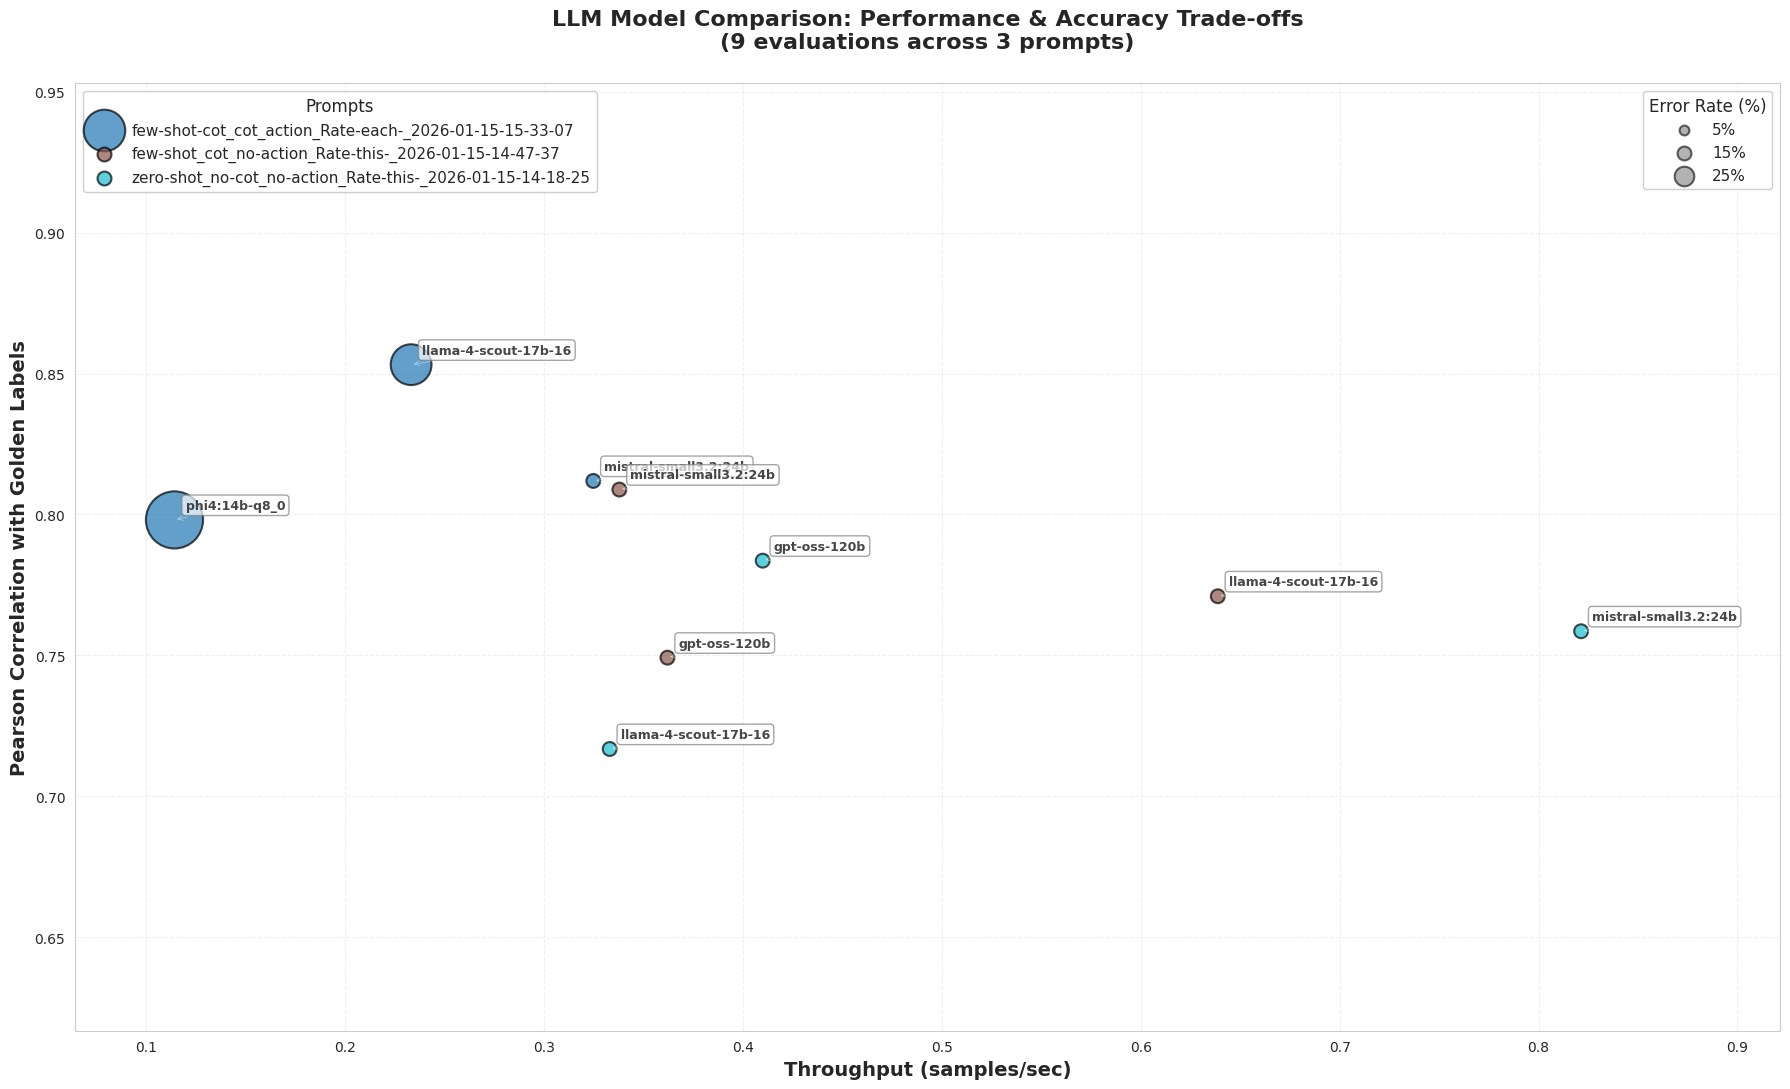

In [23]:
fig, ax = plt.subplots(figsize=(18, 11))

unique_prompts = df_metrics["prompt"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_prompts)))
prompt_color_map = {prompt: colors[i] for i, prompt in enumerate(unique_prompts)}

for prompt in unique_prompts:
    prompt_data = df_metrics[df_metrics["prompt"] == prompt]

    ax.scatter(
        prompt_data["throughput"],
        prompt_data["correlation"],
        s=prompt_data["error_rate"] * 20 + 100,
        alpha=0.7,
        color=prompt_color_map[prompt],
        edgecolors="black",
        linewidth=1.5,
        label=prompt_data["prompt_id"].iloc[0],
    )

for idx, row in df_metrics.iterrows():
    model_name = row["model_name"]
    model_short = model_name.split("/")[-1][:20]

    ax.annotate(
        model_short,
        xy=(row["throughput"], row["correlation"]),
        xytext=(8, 8),
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
        alpha=0.85,
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="gray"
        ),
        arrowprops=dict(
            arrowstyle="->", connectionstyle="arc3,rad=0", lw=0.5, alpha=0.5
        ),
    )

ax.set_xlabel("Throughput (samples/sec)", fontsize=14, fontweight="bold")
ax.set_ylabel("Pearson Correlation with Golden Labels", fontsize=14, fontweight="bold")
ax.set_title(
    "LLM Model Comparison: Performance & Accuracy Trade-offs\n"
    + f"({len(df_metrics)} evaluations across {len(unique_prompts)} prompts)",
    fontsize=16,
    fontweight="bold",
    pad=25,
)

ax.grid(True, alpha=0.3, linestyle="--")
ax.set_axisbelow(True)

legend1 = ax.legend(
    loc="upper left",
    fontsize=11,
    title="Prompts",
    title_fontsize=12,
    framealpha=0.95,
    ncol=1,
)
ax.add_artist(legend1)

size_legend_bubbles = [50, 100, 200]
size_legend_labels = ["5%", "15%", "25%"]

size_legend = ax.legend(
    [
        plt.scatter([], [], s=s, c="gray", alpha=0.6, edgecolors="black", linewidth=1.5)
        for s in size_legend_bubbles
    ],
    size_legend_labels,
    scatterpoints=1,
    title="Error Rate (%)",
    loc="upper right",
    framealpha=0.95,
    fontsize=11,
    title_fontsize=12,
)

ax.set_ylim(
    [df_metrics["correlation"].min() - 0.1, df_metrics["correlation"].max() + 0.1]
)
ax.set_xlim(
    [df_metrics["throughput"].min() - 0.05, df_metrics["throughput"].max() + 0.1]
)

plt.tight_layout()
plt.show()

In [24]:
summary_table = df_metrics.pivot_table(
    index="model_name",
    columns="prompt",
    values=["correlation", "throughput", "error_rate"],
    aggfunc="first",
)

print("Model Performance Summary (Correlation with Golden Labels):")
print("=" * 80)
print(summary_table["correlation"].round(3))

print("\n\nThroughput Summary (samples/sec):")
print("=" * 80)
print(summary_table["throughput"].round(3))

print("\n\nError Rate Summary (%):")
print("=" * 80)
print(summary_table["error_rate"].round(1))

Model Performance Summary (Correlation with Golden Labels):
prompt                                   Rate each text segment on a scale from 0-5, where higher numbers indicate greater visual descriptiveness. Select the **highest applicable rating** found in the segment.\n\n## Rating Scale\n\n**Rating 5** 🏞️ - Full vivid scene\n- Can visualize a complete scene with vivid background, foreground objects, and compelling details (e.g., time of day, lighting, atmospheric conditions)\n- Example: "The sun was setting behind the mountains, casting long shadows over the bustling village square where children played and vendors packed up their stalls."\n\n**Rating 4** 🏞️ - Full scene with details OR detailed character\n- **Option A (Scene)**: Can visualize a full scene with multiple elements - must have at least 3 of:\n  1. Background/surroundings\n  2. Action/main scene\n  3. Describable character(s)\n  4. Other visual details (each distinct detail counts separately)\n  - Example: "A river flowed

In [25]:
overall_ranking = (
    df_metrics.groupby("model_name")
    .agg({"correlation": "mean", "throughput": "mean", "error_rate": "mean"})
    .round(3)
    .sort_values("correlation", ascending=False)
)

print("\nOverall Model Rankings (Average across all prompts):")
print("=" * 80)
print(overall_ranking)


Overall Model Rankings (Average across all prompts):
                                         correlation  throughput  error_rate
model_name                                                                  
phi4:14b-q8_0                                  0.798       0.114      79.771
mistral-small3.2:24b-instruct-2506-q8_0        0.793       0.495       0.000
llama-4-scout-17b-16e-instruct                 0.780       0.402      12.723
gpt-oss-120b                                   0.766       0.386       0.000
